In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV

%matplotlib inline

In [2]:
"""
2010-2018
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

2004-2018
Datasets/data_FEC_NATIONALPOLL_2004_2018.p
Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p
"""

'\n2010-2018\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p\n\n2004-2018\nDatasets/data_FEC_NATIONALPOLL_2004_2018.p\nDatasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p\n'

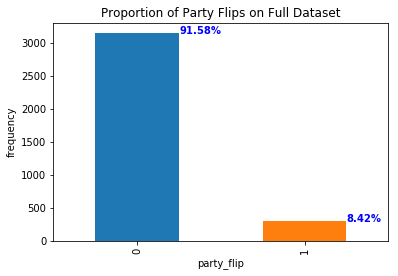

In [3]:
# Plot the proportion of flips in the full dataset

#read in FEC data
full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018.p', 'rb'))
full_dataset_redistrict = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p', 'rb'))

#add column to indicate a party flip
full_dataset['party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
full_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
full_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on Full Dataset')

for name, group in (full_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/full_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


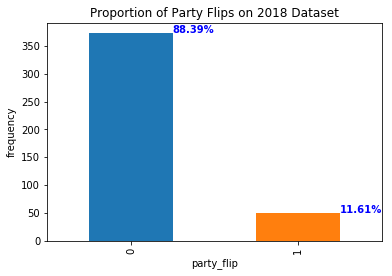

In [4]:
# Plot the proportion of flips in 2018

#add column to indicate a party flip
the_2018_dataset = full_dataset.loc[full_dataset['year']==2018,:]
the_2018_dataset.loc[:,'party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
the_2018_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
the_2018_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on 2018 Dataset')

for name, group in (the_2018_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/the_2018_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

## Code without demographics

* district
* state
* year
* party
* candidatevotes
* totalvotes
* candidate
* national_poll
* national_poll_prev
* national_poll_delta_subtract
* national_poll_delta_divide
* previous_party
* dem_win_margin_prev
* rep_win_margin_prev
* margin_signed_minus_prev
* margin_signed_divide_prev
* margin_unsigned_minus_prev
* margin_unsigned_divide_prev
* dem_win_prev
* rep_win_prev
* dem_win
* rep_win

## Variables to use

* national_poll
* margin_signed_minus_prev

* dem_win -- response

### Functions

In [5]:
# format data items for input into the model

def format_model_input(filename, cols_to_use, state_hot_encoder=False):
    
    # load full dataset 
    full_dataset = pickle.load(open(filename, 'rb'))
    
    # train data is everything except 2018
    pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]
    X_train = pre_2018_dataset[cols_to_use]
    y_train = pre_2018_dataset['dem_win']
    flip_train = np.abs(pre_2018_dataset['dem_win']-pre_2018_dataset['dem_win_prev'])
    
    # test data is 2018
    the_2018_dataset = full_dataset.loc[full_dataset['year']==2018]
    X_test = the_2018_dataset[cols_to_use]
    y_test = the_2018_dataset['dem_win']
    flip_test = np.abs(the_2018_dataset['dem_win']-the_2018_dataset['dem_win_prev'])
    
    if state_hot_encoder:
        #add one hot encoder for states (with or without dropping first)
        X_train.loc[:,'state'] = pre_2018_dataset['state']
        X_train = pd.get_dummies(X_train,prefix='state',columns=['state'], drop_first=True)
        X_test.loc[:,'state'] = the_2018_dataset['state']
        X_test = pd.get_dummies(X_test,prefix='state',columns=['state'], drop_first=True)
    
    return X_train,y_train, X_test,y_test, flip_train,flip_test

In [6]:
# plot flips predicted by a model

def plot_flips(X_test_input, y_test_input, y_pred_test_input, flip_train, 
               flip_test, model_name):
    
    # copy arrays so you don't accidentally change them 
    X_test = X_test_input.copy()
    y_test = y_test_input.copy()
    y_pred_test = y_pred_test_input.copy()
    
    # add flip data to the array
    X_test['party_flip'] = flip_test
    
    #looking at the missclassifications with logisticRegressionCV
    miss_class_df = X_test[y_test != y_pred_test]
    good_class_df = X_test[y_test == y_pred_test]

    #plot the flips and non flips for each data
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].set_title(model_name+' Proportion of party flips on wellclassified test data')
    ax[1].set_title(model_name+' Proportion of party flips missclassified test data')

    good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
    miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])

    for name, group in (good_class_df.groupby('party_flip')['party_flip']):
        ax[0].text(int(name)+.25, group.count() + .25, \
        '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
        ax[1].text(int(name)+.15, group.count() + .25, \
        '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')
    
    plt.show()

In [7]:
# print out R2, accuracy, and plot # flipped seats correctly predicted for a given model

def report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder=False):
    
    # read in the desired data
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, state_hot_encoder)
    
    fitted_model_dict = {}
    for model_name, model in model_dict.items():
        print(model_name)

        fitted_model = model.fit(X_train,y_train)
        y_pred_test = fitted_model.predict(X_test)

        print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test))

        print("\n{} R2: ".format(model_name), fitted_model.score(X_train,y_train))
        print("{} Test Accuracy".format(model_name), accuracy_score(y_test,y_pred_test))

        plot_flips(X_test, y_test, y_pred_test, flip_train, flip_test, model_name)
        
        fitted_model_dict[model_name] = fitted_model
    
    return fitted_model_dict

### Try out different models and columns

#### Full dataset, no demographics, not dropping any data. 

In [8]:
# specify your models here:
model_dict = {
    'LogRegCV'      : LogisticRegressionCV(cv=5,random_state=209,multi_class='ovr',n_jobs=4),
    'kNN'           : KNeighborsClassifier(n_neighbors=10,n_jobs=4),
    'Random Forest' : RandomForestClassifier(n_jobs=4,random_state=209),
    'AdaBoost'      : AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)),
    'LASSO'         : LassoCV(cv=5)
}

/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


LogRegCV
Confusion Matrix: 
 [[179  17]
 [ 23 203]]

LogRegCV R2:  0.8570953805250914
LogRegCV Test Accuracy 0.9052132701421801


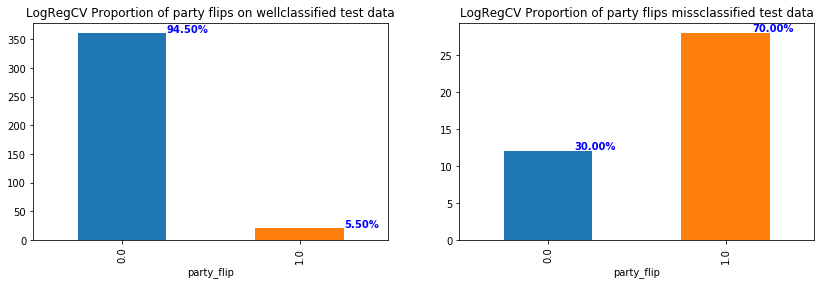

kNN
Confusion Matrix: 
 [[191   5]
 [ 44 182]]

kNN R2:  0.9305417082087072
kNN Test Accuracy 0.8838862559241706


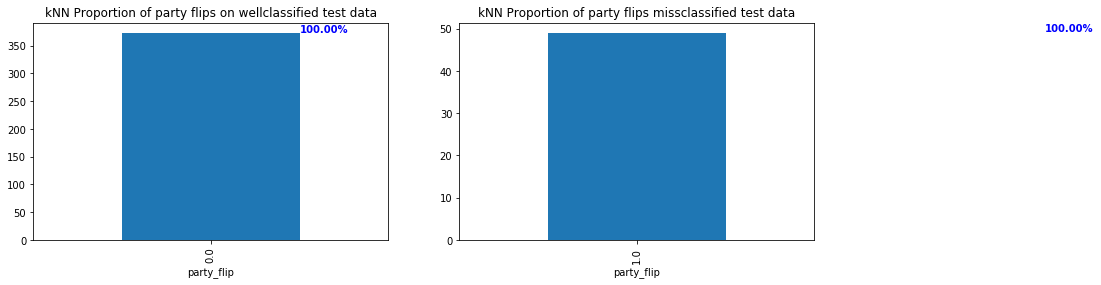

Random Forest


/Users/Elise/miniconda2/envs/cs209/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix: 
 [[191   5]
 [ 44 182]]

Random Forest R2:  0.9890329012961117
Random Forest Test Accuracy 0.8838862559241706


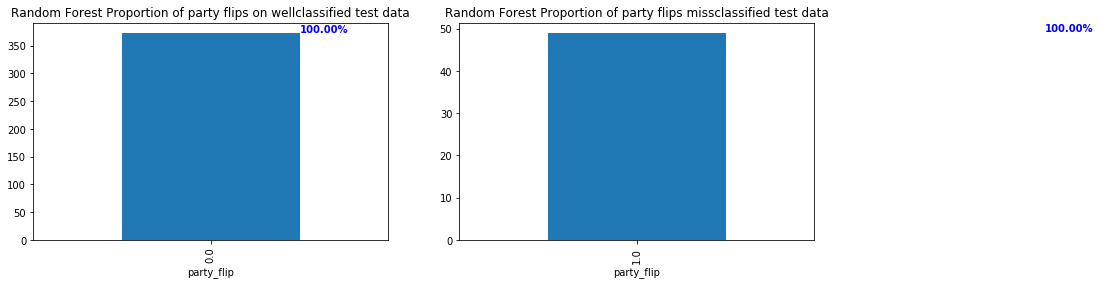

AdaBoost
Confusion Matrix: 
 [[187   9]
 [ 42 184]]

AdaBoost R2:  0.9468261881023596
AdaBoost Test Accuracy 0.8791469194312796


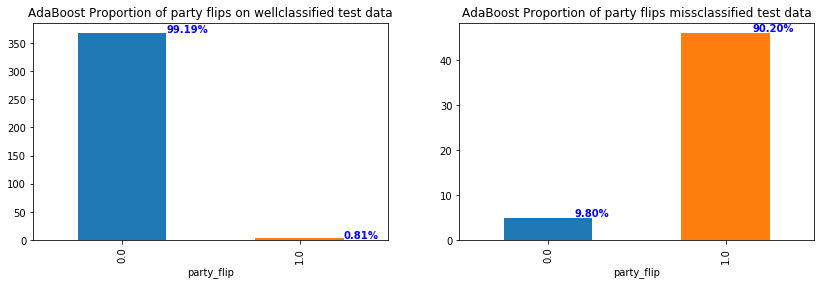

LASSO


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [9]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them

report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder=True,)

### Full dataset, no demographics, dropping redistricted states

In [ ]:
# specify columns to use and the file you want to read in 
"""
2010-2018
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

"""
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
# cols_to_use same as above
X_train,y_train, X_test,y_test, flip_train,flip_test = \
    format_model_input(filename, cols_to_use, state_hot_encoder=True)

fitted_models = report_model_stats(model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test)

### Selected columns in the full dataset, no demographics

### Selected columns in the full dataset, no demographics, dropping redistricted states

### Selected columns in the full dataset, no demographics, imputing redistricted states

### Dataset since 2010, with demographics, nothing dropped

In [ ]:
# specify columns to use and the file you want to read in 
"""
2010-2018
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

"""
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
cols_to_use = [] # todo
X_train,y_train, X_test,y_test, flip_train,flip_test = \
    format_model_input(filename, cols_to_use, state_hot_encoder=True)

fitted_models = report_model_stats(model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test)

### Dataset since 2010, with demographics, dropping redistricted states

In [ ]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p'
# cols_to_use same as above
X_train,y_train, X_test,y_test, flip_train,flip_test = \
    format_model_input(filename, cols_to_use, state_hot_encoder=True)

fitted_models = report_model_stats(model_dict, X_train, y_train, X_test, y_test, flip_train, flip_test)

### Selected columns in dataset since 2010, with demographics, nothing dropped

### Selected columns in dataset since 2010, with demographics, dropping redistricted states

## Impute 2010 data into all non-redistricted districts in prior years. 

In [ ]:
"""
thanks, Manish!

data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018.csv
data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018.p

"""

## Try different k's for kNN 

In [ ]:
#Try KNN
k_values =[1,3,5,10,25,100,500]
k_score = []
k_test_accuracy =[]
k_models =[]

for i in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=i,n_jobs=4)
    knn_model.fit(X_train,y_train)
    k_models.append(knn_model)
    k_score.append(knn_model.score(X_train,y_train))
    y_pred_test = knn_model.predict(X_test)
    k_test_accuracy.append(accuracy_score(y_test,y_pred_test))
    
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(k_values,k_score)
ax[1].scatter(k_values,k_test_accuracy)
ax[0].set_xticklabels(k_values)

ax[0].set_title("R2score vs. K")
ax[1].set_title("Test Accuracy vs. K")

ax[0].set_xlabel("K values")
ax[0].set_ylabel("r2_score")
ax[1].set_xlabel("K values")
ax[1].set_ylabel("Test Accuracy")  
print("\n")

###  NOTES:

1. Logistic CV 90% of the missclassified data occurs when there is a change of party compared to the previous year. No state flips are predicted correctly. 
2. KNN, 100% of the missclassified data occurs when there is a change of party. 5% of the well classified data is party flip. (Better performance)
3. Predicts correctly 100% of the districts that do not change, and ...

Concentrate on improving the states that flip to a different party between elections

Ideas
0. Try non-linear approaches (KNN, Random Forest and Boosting)
1. Increase data by Upsampling and downsampling
2. Increase data by adding more historical data
3. Add demographics data
4. Add redistricting